### Explanation
This code analyse time lapse images of plates with growing colonies and get colony valuable data like size and mean fluorescence over time.

##### Requirements
 - All images have to be same size


## Analysis

### Loading packages

In [1]:
# import some useful packages to manage the data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#modify some matplotlib parameters to manage the images on illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
#we use scikit-image to analyse the images
import skimage 
from skimage import io, filters

### Loading Data

Define the folder name where the images are stored

In [3]:
#note: all the folder used here are ablable in this drive --> https://goo.gl/Trg1DX 

fname =  "D:\Dropbox\FTI\Raspiscope\Time lapse\Lab_27_1_17_pLac\image_%04d.jpg"
#refered to drive folder Lab_27_1_17_pLac


print(fname%(0))   # just to see if names are well defined

D:\Dropbox\FTI\Raspiscope\Time lapse\Lab_27_1_17_pLac\image_0000.jpg


#### Understanding and visualizing the Data

We use PyPlot to read the file into a numpy array (*imread*). This is a 3-dimensional array (a grid of values) with dimensions x,y,c, with (x,y) position and c the color channel (red, green, blue). 

<img src="files/imagearray.png" width=256 height=256>

We can use PyPlot again to display the array (*imshow*), which interprets the array as a color image correctly.

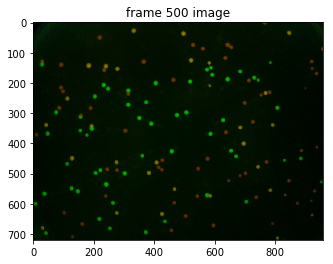

In [4]:
#let's try this with the frame 500 image 

plt.figure()
im1 = plt.imread(fname%500)
plt.imshow(im1)
plt.title('frame '+str(500)+' image')


Or we can show channels separately 

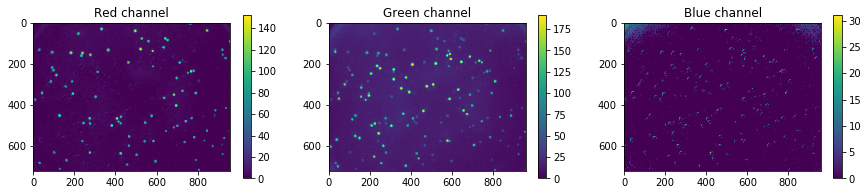

In [5]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.imshow(im1[:,:,0])
plt.colorbar()
plt.title('Red channel')

plt.subplot(132)
plt.imshow(im1[:,:,1])
plt.colorbar()
plt.title('Green channel')

plt.subplot(133)
plt.imshow(im1[:,:,2])
plt.colorbar()
plt.title('Blue channel')

Each pixel of each channel can take a value between 0 to 255, which value is indicated accord the colorbar at the side of each plot.


---
#### Taking some data measures
Then, we are interested in get the **size of the image** 

We can get it from the numpy array shape 

The 3rd dimension size is 3 for R,G,B --> We dont need it, so use the "_" variable.

In [7]:
w,h,_ = im1.shape
print('w= '+str(w),'  h= '+str(h))

w= 720   h= 960


#### Loading the time series images
There are 3 channels in each image (R,G,B). 
We will load each channel of all the images into a 3-dimensional array, with dimensions x, y, time. 

<img src="files/TempMatrix.png" width=800 height=256>

-----
As every image is a timepoint value, we should count the total number of images we have in the folder to know the total timepoints

In [8]:
#define a function to count the images on the folder and import the "glob" library used to do that
import glob
def count_files(path,filetype):
    #inputs: path and filetype (e.g. tif, png, jpg)
    #output: number of defined filetype files on the path folder (integer)
    
    imageCount = len(glob.glob1(path,"*."+filetype))
    print(path.split('\\')[-1]+' = '+str(imageCount) + ' files')
    return(imageCount)

In [9]:
imCount=count_files('D:\Dropbox\FTI\Raspiscope\Time lapse\Lab_27_1_17_pLac',"jpg")

Lab_27_1_17_pLac = 600 files


Also, set the function to read images and save his values on the 3-dimensional array (for each channel)

In [10]:
def get_im_data(xframes,imageCount,fname):
 #inputs:
  #xframes = step frames (e.g. 10 to use only ten to ten images)
  #imageCount = total number of files
  #fname = folder name
  
 #outputs:
   #imsR,imsG,imsB: data per channel of each image (imsR=matrix size (w,h,imagecount/xframes))

    w,h,_ = plt.imread(fname%1).shape      #measure the image size based on the first image on the folder
    nt = int(imageCount/xframes)
    imsR = np.zeros((w,h,nt))
    imsG = np.zeros((w,h,nt))
    imsB = np.zeros((w,h,nt))
    for i in range(0,nt):
        im = plt.imread(fname%(i*xframes))
        imsR[:,:,i] = im[:,:,0]              #last number code the channel: 0=red, 1=green, 2=blue
        imsG[:,:,i] = im[:,:,1]
        imsB[:,:,i] = im[:,:,2]
    return(imsR,imsG,imsB)

# when call you can take only the channels you are interested in (e.g.):
# red,_,blue=get_im_data(xframes,imageCount)  ---> this only takes the red and blue channels

Now we can use this function to read and store the data of the images on a defined array for each channel

In [11]:
DataS={}
Frames=12   # use one image every 12 frames
DataS['R'],DataS['G'],DataS['B']=get_im_data(Frames,imCount,fname)
DataS['Im']=fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

Finally is important know the time step value used on the timelapse. It can be know from the python timelapse code stored on the folder (named 'interval' on the code).

In [12]:
#define it on hour units
dT= 1/12  #hours

#in this example interval = 5 min for each frame


Whit it, we can construct a **time vector** 'T' for *DataS*

In [13]:
_,_,st=DataS['R'].shape
T=np.zeros((st))
for i in range(0,st):
    T[i]=(i+1)*Frames*dT
    

### Data management

#### Background computation and substraction

To take the valuable data of images is good to know the amount of background we have on it, if it changes over time or how noisy is it.

By ploting a transect of pixel values for each channel on an image, we can figure the efect of background: 

In [15]:
# get the background time value and plot it

def row_transect(Data, row, frame = -1):    
    #input: 
    # row = the row where you want to see the transect  (integer)
    # frame = image frame to use  (integer), default = last one
    
    plt.figure(figsize=(15,3))
    plt.subplot(131)
    plt.plot(Data['R'][row,:,frame])
    plt.xlabel('pixels')
    plt.ylabel('value')
    plt.title('Red channel')

    plt.subplot(132)
    plt.plot(Data['G'][row,:,frame])
    plt.xlabel('pixels')
    plt.title('Green channel')

    plt.subplot(133)
    plt.plot(Data['B'][row,:,frame])
    plt.xlabel('pixels')
    plt.title('Blue channel')
    
    #plot selected line transect on the image (allways show it on the last frame)
    
    im = plt.imread(Data['Im']%(imCount-1))
    s1,s2,_=im.shape
    plt.figure(figsize=(6,6))
    fig = plt.gcf()
    ax = fig.gca()
    ax.imshow(im)
    rect = matplotlib.patches.Rectangle((0,row),s2,0,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


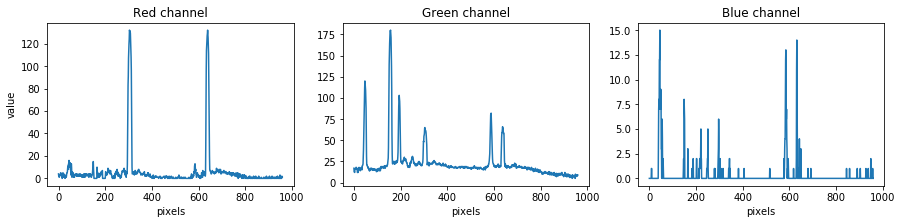

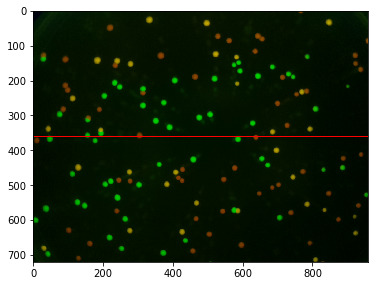

In [16]:
row_transect(DataS,w/2)

As you can see, data show some "picks" (suposed to be colonies) and a basal value along the line (suposed to be agar background signal)

Then, to distinguish cell fluorescence from media and background light, we can select some empty sector on the image (i.e. without colonies) and compute his mean value on each frame.

In [17]:
def BG_Val(X1,X2,Y1,Y2,data):
    #X1,X2,Y1,Y2 --> rectangle area limits: (X1,Y1)--> left-up corner. (X2,Y2) ---> rigth-bottom corner
    #data = the desired channel data to get the background
    
    X2R=X2-X1 #convert on steps because the rectangle patch definition
    Y2R=Y2-Y1
    
    #plot the defined area
    plt.figure(figsize=(8,8))
    fig = plt.gcf()
    ax = fig.gca()
    im = plt.imread(data['Im']%(imCount-1))
    ax.imshow(im)
    rect = matplotlib.patches.Rectangle((Y1,X1),Y2R,X2R,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    
    #get the background time value and plot it
    bg=np.zeros((3,data['R'].shape[2]))
    count=0
    for chan in channels:
        bg[count,:] = data[chan][X1:X2,Y1:Y2,:].mean(axis=(0,1))
        count=count+1
        
    plt.figure()
    plt.plot(bg[0,:],'r')
    plt.hold(True)
    plt.plot(bg[1,:],'g')
    plt.plot(bg[2,:],'b')
    
    plt.xlabel('Time step')
    plt.ylabel('Fluorescence intensity')
        
        
    
    return(bg)

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


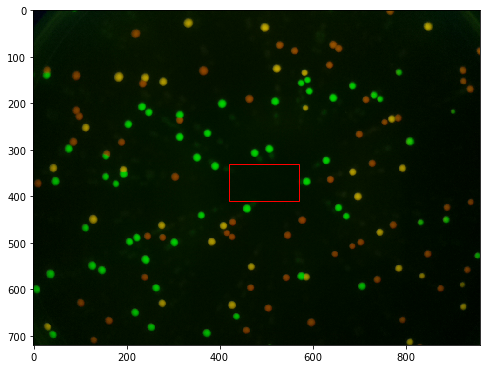

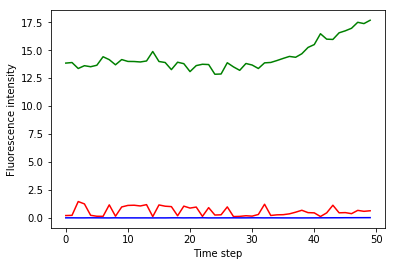

In [18]:
BG=BG_Val(330,410,420,570,DataS)

we can substract that vector value to each frame on the image to eliminate the background effect

To perform it we can define the next function

In [19]:
def BG_subst(Data,bg):
 #inputs
    # Data = image Data
    # bg = Background mean value for each channel and time step
 #return
    # Data = original matrix with the bacground substracted
    
    l=bg.shape[1]
    s1=Data['R'].shape[0]
    s2=Data['R'].shape[1]
    j=0
    for c in channels:
        for i in range(0,l):
            bgm=np.ones((s1,s2))
            bgm= bgm*bg[j,i]         #create a matrix with bg to substract it to the frame
            
            data=Data[c][:,:,i]
            
            data=data-bgm         #perform the substraction
            
            data[data<0]=0        # values < 0 are not allowed --> transform it to 0
            
            Data[c][:,:,i]=data   #actualize Data
        
        j+=1  #to actualize background channel
    
    return(Data)

Then we use the function to obtain the clean data

In [20]:
DataSB=BG_subst(DataS,BG)

and we can check the effect on the background

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


array([[ 0.17148275,  0.18170767,  0.4094045 ,  0.36221043,  0.18617783,
         0.130189  ,  0.12436233,  0.33061717,  0.13233089,  0.31383275,
         0.30747929,  0.30328053,  0.30663711,  0.32209692,  0.10756812,
         0.31393964,  0.29686817,  0.28621847,  0.15832028,  0.28783034,
         0.29947813,  0.2702276 ,  0.1217686 ,  0.29635486,  0.20043756,
         0.21215342,  0.28665087,  0.1084556 ,  0.12304818,  0.15944183,
         0.13708568,  0.22610389,  0.33508999,  0.17563228,  0.20889383,
         0.21602987,  0.25113622,  0.29953   ,  0.31554116,  0.29715715,
         0.29824455,  0.11288762,  0.30824656,  0.37517782,  0.314873  ,
         0.31416   ,  0.27522   ,  0.36872122,  0.34558672,  0.35936044],
       [ 0.30897455,  0.30298353,  0.4407549 ,  0.44251331,  0.39306882,
         0.34314811,  0.43045629,  0.37142   ,  0.34111872,  0.36527024,
         0.34995328,  0.34914561,  0.37817188,  0.36508   ,  0.41929542,
         0.35815214,  0.390546  ,  0.43702106,  0.

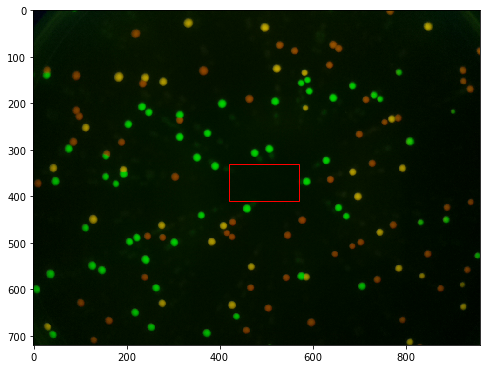

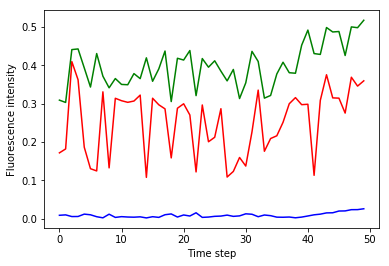

In [21]:
BG_Val(330,410,420,570,DataSB)

Background was practically eliminated

### Get colony position
Here we are interested on identify the place where colonies are situated

A good way to do it is by sum the value of each pixel for all the channels and all the frames

In [22]:
def dataOT(Data):
    
    SData=Data['R'][:,:,:].sum(axis=(2))+Data['G'][:,:,:].sum(axis=(2))+Data['B'][:,:,:].sum(axis=(2))
    plt.imshow(SData)
    plt.colorbar()
    plt.title('All channels')
    
    return(SData)


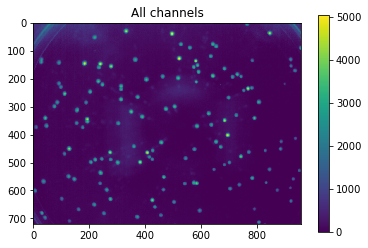

In [23]:
SumData=dataOT(DataSB)

Now we can see each colony as a more clear point

To improve the border detection and reduce the noise is recommended  to apply a filter to smooth the data:

In [24]:
# skimage have a usefull gaussian filter for this task
from skimage.filters import gaussian

In [25]:
def smoothDat(data,sigma):
 #inputs
    # data = 4 dimensional matrix with the data
    # sigma = filter parameter (standard deviation)
 #return
    # nsims = dictionary with smooth data of each channel sum over time
    # nsimsAll = matrix with sum of each channels of nsims
    
    nsims={}
    nsimsAll=np.zeros((data['R'].shape[0],data['R'].shape[1]))
    
    plt.figure(figsize=(17,3))
    pvect = [131,132,133]
    count=0
    
    for c in channels:
        # apply filter
        data_sum = data[c].sum(axis=2)
        sims= gaussian(data_sum, sigma)
        nsims [c]= (sims-sims.min())/(sims.max()-sims.min())
        
        nsimsAll += nsims[c]
        # make plot
    
        plt.subplot(pvect[count])
        plt.imshow(nsims[c])
        plt.colorbar()
        plt.title(c+' channel')
    
        count+=1
    
    return(nsims,nsimsAll)


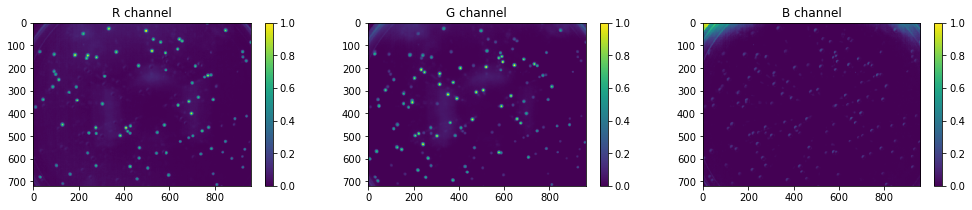

In [27]:
sDatS,sDatSall=smoothDat(DataSB,1.5)

And we can see the plot of the sumarized result

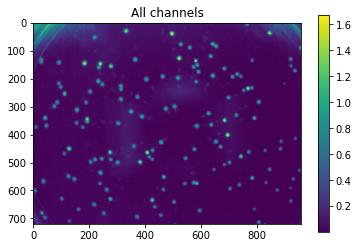

In [28]:
    plt.imshow(sDatSall)
    plt.colorbar()
    plt.title('All channels')

#### Blob detection
Scikit-image provides several functions to detect Gaussian-like features ([blobs](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html)). We apply one of these ([blob_log](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log)) to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

In [29]:
import skimage.feature as skfeat

In [51]:
def colonyBlob(data,thresh,ImName):
    A = skfeat.blob_log(data, min_sigma=1.0, max_sigma=10.0, num_sigma=100, threshold=thresh, overlap=0.8)
    
    plt.figure(figsize=(8,8))
    plt.imshow(data, cmap='gray')
    plt.hold(True)
    plt.title('sumarized Image')
    for i in range(len(A)):
        circle = plt.Circle((A[i,1], A[i,0]), 2*A[i,2], color='r', fill=False , lw=0.5)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)
    
    plt.figure(figsize=(8,8))
    plt.imshow(plt.imread(ImName))
    plt.hold(True)
    plt.title('Original Image')
    for i in range(len(A)):
        # plot the circle area identified for each colony
        circle = plt.Circle((A[i,1], A[i,0]), 2*A[i,2], color='w', fill=False , lw=0.5)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        # attach the ID label to each colony
        plt.annotate(
        i,
        xy=(A[i,1], A[i,0]), xytext=(-2, 2),
        textcoords='offset points', ha='right', va='bottom',color='white')
    plt.savefig("ColonyID2.pdf", transparent=True)
        
    return(A)

To properly identification, it's important to set the threshold for each dataset manually (based on the previous colormap)

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


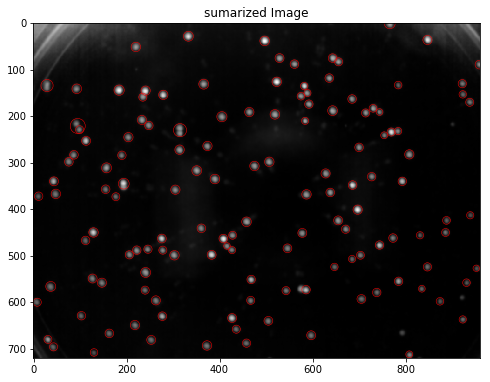

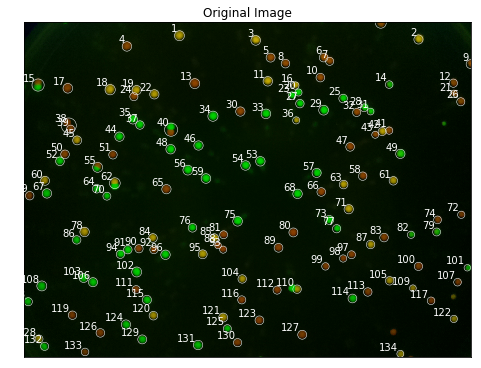

In [52]:
blobD = colonyBlob(sDatSall,0.26,fname%599)

In [40]:
print(blobD) # [x position, y position , std deviation of the radious]

[[   0.          766.            5.90909091]
 [  28.          333.            5.36363636]
 [  36.          847.            4.90909091]
 [  38.          497.            5.18181818]
 [  51.          220.            5.09090909]
 [  75.          529.            4.81818182]
 [  75.          643.            4.63636364]
 [  83.          656.            4.36363636]
 [  88.          561.            4.63636364]
 [  89.          959.            4.72727273]
 [ 118.          636.            4.63636364]
 [ 126.          523.            5.09090909]
 [ 130.          922.            4.45454545]
 [ 131.          366.            5.36363636]
 [ 133.          784.            4.09090909]
 [ 134.           29.            6.54545455]
 [ 135.          582.            4.        ]
 [ 141.           93.            5.18181818]
 [ 144.          184.            5.54545455]
 [ 145.          241.            5.        ]
 [ 150.          589.            3.81818182]
 [ 153.          923.            4.        ]
 [ 154.   

With the previous procedure we have identificated where each colony is placed

To perform further analysis on each colony is necesary to store these regions of interest (ROI) and his data, with size given by the Gaussian width (x2 = 2 standard deviations).

In [41]:
def obtain_rois(data,blobs):
 #inputs
    # data = matrix with sum in channels and time of the images
    # blobs = matrix with all the information of the obtainesd blobls (output from colonyBlob function)
 #return
    # all_rois = array with the information of the region of interest (square arund the colony)
    # all_rois_circle = array with the information inside the area of the colony (makes the values outside the colony equals to zero)
    # nc = number of colonies ( equals to the length of rois vector) 

    all_rois = {}
    all_rois_circle = {}
    nc= len(blobs)
    
    for char in channels:
        rois = {}
        rois_circle = {}
        
        for i in range(nc):
            x = blobs[i,0]
            y = blobs[i,1]
            r = 2*blobs[i,2] #blobs[i,2] is the std deviation of the radious --> r=2*std implies 95% confidence

####### this lines is to eliminate the out of image bounds error          
            x1=x-r
            x2=x+r
            y1=y-r
            y2=y+r
            
            if x1 <= 0:
                x1 = 0
            if x2 >= data[char].shape[0]:
                x2 = data[char].shape[0]
            if y1 <= 0:
                y1 = 0
            if y2 >= data[char].shape[1]:
                y2 = data[char].shape[1]
            
            rois[i] = data[char][x1:x2,y1:y2,:]    
#######            
            xr=int((rois[i].shape[0]+1)/2)
            yr=int((rois[i].shape[1]+1)/2)
            rois_circle[i]=np.zeros((rois[i].shape))
            for n in range(rois[i].shape[0]):
                for m in range(rois[i].shape[1]):
                    if ((n-xr)**2+(m-yr)**2) <= (r**2):
                        rois_circle[i][n,m,:] = rois[i][n,m,:]
        all_rois[char] = rois
        all_rois_circle[char] = rois_circle
    
    return(all_rois,all_rois_circle,nc)

# rois contains a square arund the colony
# roisC makes the values outside the colony equals to zero

# to call it:
# roisC['channel_name'][blob_number][y,x,timepoint]

In [398]:
def obtain_rois(data,blobs):
 #inputs
    # data = matrix with sum in channels and time of the images
    # blobs = matrix with all the information of the obtainesd blobls (output from colonyBlob function)
 #return
    # rois = array with the information of the region of interest (square arund the colony)
    # rois_circle = array with the information inside the area of the colony (makes the values outside the colony equals to zero)
    # nc = number of colonies ( equals to the length of rois vector)
    rois = {}
    rois_circle = {}
        
    for i in range(len(blobs)):
        x = blobs[i,0]
        y = blobs[i,1]
        r = 2*blobs[i,2] #blobs[i,2] is the std deviation of the radious --> r=2*std implies 95% confidence

####### this lines is to eliminate the out of image boundaries error          
        x1=x-r
        x2=x+r
        y1=y-r
        y2=y+r
            
        if x1 <= 0:
            x1 = 0
        if x2 >= data.shape[0]:
            x2 = data.shape[0]
        if y1 <= 0:
            y1 = 0
        if y2 >= data.shape[1]:
            y2 = data.shape[1]
            
        rois[i] = data[x1:x2,y1:y2]    
#######            
        xr=int((rois[i].shape[0]+1)/2)
        yr=int((rois[i].shape[1]+1)/2)
        rois_circle[i]=np.zeros((rois[i].shape))
        for n in range(rois[i].shape[0]):
            for m in range(rois[i].shape[1]):
                if ((n-xr)**2+(m-yr)**2) <= (r**2):
                    rois_circle[i][n,m] = rois[i][n,m]
        nc= len(rois)

    
    return(rois,rois_circle,nc)

# rois contains a square arund the colony
# roisC makes the values outside the colony equals to zero

# to call it:
# roisC[blob_number][x,y]

In [42]:
Rois,RoisC,NC = obtain_rois(DataSB,blobD)

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


we can ilustrate the data with the first blob (colony)

In [43]:
# show the first column of the first ROI
print(Rois['R'][0][:,1,1])
print(RoisC['R'][0][:,1,1]) #it contains only the pixels inside the circular region

[ 0.          0.76933333  2.76933333  3.76933333  1.76933333  0.
  0.76933333  0.76933333  0.76933333  0.76933333  0.        ]
[ 0.          0.          2.76933333  3.76933333  1.76933333  0.
  0.76933333  0.76933333  0.76933333  0.76933333  0.        ]


### Time dynamics of colonies
As we have estimated colony location (and maximmum size), we can analyse the dynamics of fluorescence and growth of them. 

#### Fluorescence dynamics
we should start by ploting the dynamics of total fluorescence value for each ROI

In [47]:
def rois_plt_Fdynam(rois,T,nc):
    plt.figure(figsize=(17,3))
    pvect = [131,132,133]
    count=0
    for c in channels:
        plt.subplot(pvect[count])
        for i in range(nc):
            plt.plot(T,rois[c][i].sum(axis=(0,1)))   #sum the value 
            plt.hold(True)
            
        plt.xlabel('Time [hrs]')
        plt.ylabel('Fluorescence intensity')
        plt.title(c+' channel')
        count+=1
    plt.savefig("FluorIntRGB.pdf", transparent=True)      
#plt.legend(['Colony %d'%i for i in range(len(A))])

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


Each line correspond to a different ROI


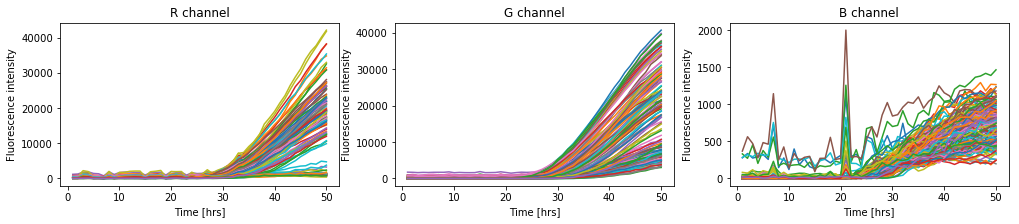

In [48]:
rois_plt_Fdynam(RoisC,T,NC)
print('Each line correspond to a different ROI')

#### Colony radius growth
We have the location and some kind of size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is to find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse.This is very slow

First we perform the sum of all channels for each frame to get the best representation of colony size:

In [53]:
def channelSum(RData,nc):
 #input
    # RData = RGB time-lapse image data of each ROIS
 #return
    # ACdata = sum of channels for each time step
    ACrois = {}
    for i in range(nc):
            ACrois[i]=np.zeros((RData['R'][i].shape))
    
    for c in channels:
        for i in range(nc):
            ACrois[i]+=RData[c][i][:,:,:]
            
    return(ACrois)

In [54]:
ACRois=channelSum(RoisC,NC)

In [101]:
ACRoisS=channelSum(Rois,NC) #square ROIS

The following loop finds blobs and stores the width in each frame. The result is a dict containing the size at each time point for every colony

In [55]:
def frame_colony_size(rois,nc,thr): 
    R = {}
    nt= rois[0].shape[2]
    for k in range(nc):
        R[k] = np.zeros((nt,))
        for i in range(nt):
            troi = rois[k][:,:,i].astype(np.float32)
            if len(troi):
                ntroi = (troi-troi.min())/(troi.max()-troi.min())
                AA = skfeat.blob_log(ntroi, min_sigma=1.0, max_sigma=10.0, num_sigma=200, threshold=thr, overlap=0.8)
                if len(AA)>0:
                    R[k][i] = AA[0,2]
    return(R)

In [56]:
R_frame=frame_colony_size(ACRois,NC,0.25)

In [502]:
R_frame=frame_colony_size(ACRois,NC,0.28)

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Prosimio\Anaconda3\lib\site-packages\skimage\util\dtype.py:204: RuntimeWarning: invalid value encountered in less
  if np.min(image) < -1.0 or np.max(image) > 1.0:
C:\Users\Prosimio\Anaconda3\lib\site-packages\skimage\util\dtype.py:204: RuntimeWarning: invalid value encountered in greater
  if np.min(image) < -1.0 or np.max(image) > 1.0:
C:\Users\Prosimio\Anaconda3\lib\site-packages\skimage\feature\peak.py:159: RuntimeWarning: invalid value encountered in greater
  mask &= image > max(thresholds)


In [57]:
import time

start = time.time()
R_frame2=frame_colony_size(ACRois,NC,0.27)
end = time.time()
print(end - start)

733.1829354763031


In [61]:
start = time.time()
R_frame3=frame_colony_size(ACRois,NC,0.29)
end = time.time()
print(end - start)

769.5750172138214


In [236]:
start = time.time()
R_frame4=frame_colony_size(ACRois,NC,0.35)
end = time.time()
print(end - start)

960.3169269561768


Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

In [63]:
def plot_growth(R,t):
    for i in range(len(R)):
        r = R[i]
        plt.plot(t,np.log(r*r), '.')
        plt.hold(True)
        plt.xlabel('Time [hrs]')
        plt.ylabel('log(Radius^2) [pixels]')
        plt.title('Colony size')
    plt.savefig("Radio.pdf", transparent=True) 
        

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in log
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


Each line correspond to one colony


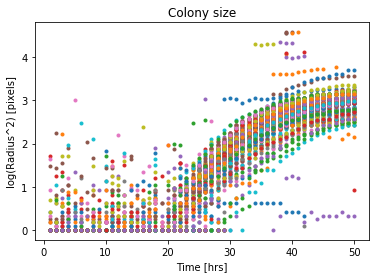

In [59]:
plot_growth(R_frame,T)
print('Each line correspond to one colony')

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in log
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


Each line correspond to one colony


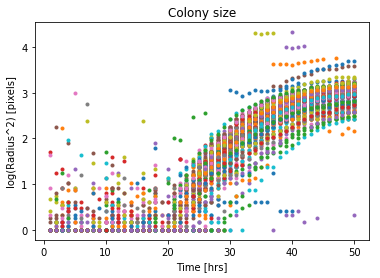

In [60]:
plot_growth(R_frame2,T)
print('Each line correspond to one colony')

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in log
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


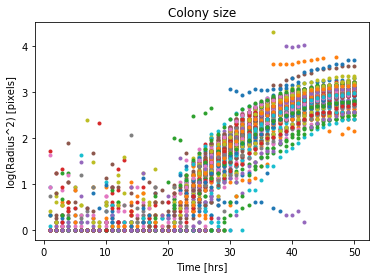

In [64]:
plot_growth(R_frame3,T)


C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in log
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


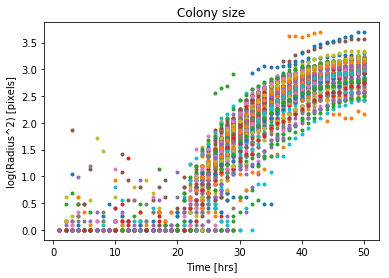

In [237]:
plot_growth(R_frame4,T)


#### Check the radius estimate
To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

In [112]:
def checkR(R,rois,idx,t):
    plt.figure(figsize=(16,12))
    w,h,_ = rois[idx].shape
    plt.imshow(rois[idx][w/2+1,:,:], interpolation='none', cmap='gray') # use the x-middle transect (--> w/2+1)
    plt.colorbar()
    plt.hold(True)
    plt.plot(t,-R[idx]*2+h/2+1,'r')
    plt.plot(t,R[idx]*2+h/2+1,'r')
    plt.xlabel('Time')
    plt.ylabel('y-axis position')
    plt.savefig("KymoGraph.pdf", transparent=True) 

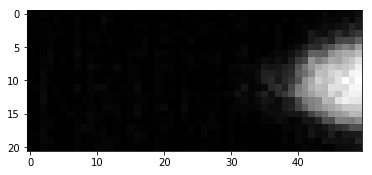

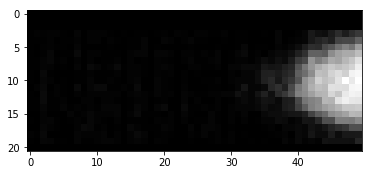

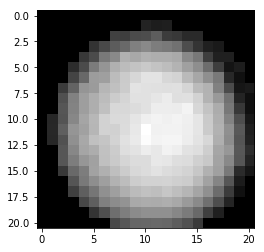

In [109]:
IDCol=67
plt.figure()
plt.imshow(ACRoisS[IDCol][5,:,:], interpolation='none', cmap='gray')
plt.figure()
plt.imshow(ACRois[IDCol][5,:,:], interpolation='none', cmap='gray')
plt.figure()
plt.imshow(ACRois[IDCol][:,:,-1], interpolation='none', cmap='gray')

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


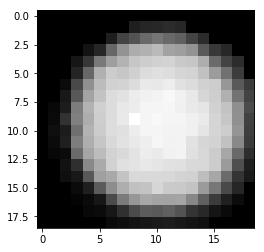

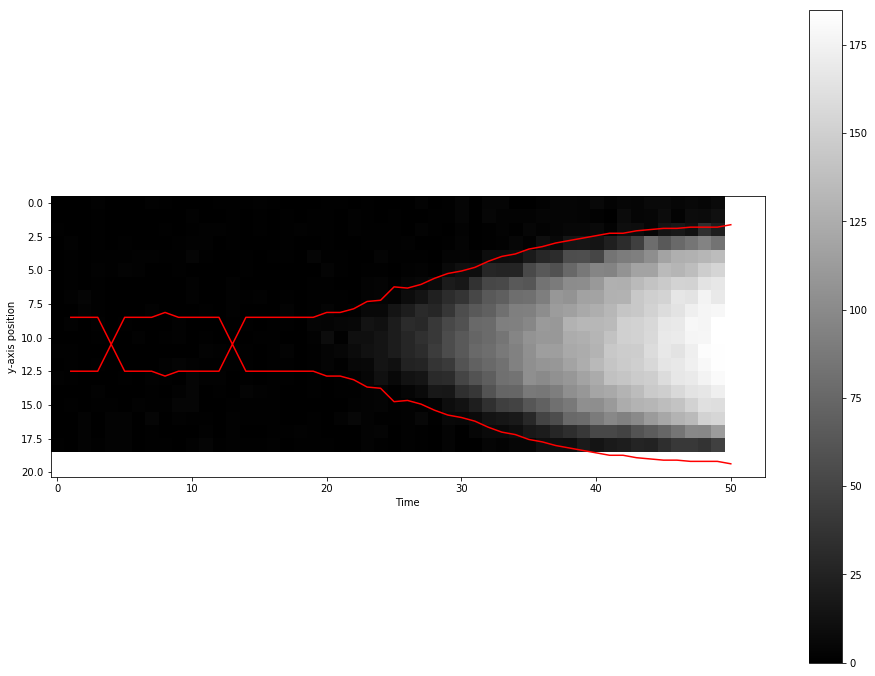

In [113]:
IDCol=66
plt.figure()
plt.imshow(ACRois[IDCol][:,:,-1], interpolation='none', cmap='gray')
checkR(R_frame3,ACRoisS,IDCol,T)


To improve determination of radio we can fix a monotonically incresing function to the obstained values for each colony. This function could be of sigmodial type:
\begin{equation}
r(t) = \frac{a}{1+ e^{-d(t+b)}}
\end{equation}

In [142]:
from scipy.optimize import curve_fit

In [195]:
def F_sigma(t, a, b, c):
    return((a /(1+np.exp(-(t+b)*c))))
    #return((a /(1+np.exp(-(t+b)*c)))+d)

In [228]:
def Function_fit(xdata,ydata,init,end,ID):
    #data1 = time
    z,_=curve_fit(F_sigma,xdata[init:end], ydata[init:end],bounds=([1,-np.inf,0.1],[np.inf,-1,1]))
    print(z)
    #FunValues=np.zeros((len(xdata)))
    evalF=F_sigma(xdata,z[0],z[1],z[2])
    #evalF=F_sigma(xdata,z[0],z[1],z[2],z[3])
    #plt.plot(timeC[init:end], ratio[init:end,i], '.', xp, p(xp), '-')
    #axisMax=np.max([np.max(xdata),np.max(ydata)])
    #axisMin=np.min([np.min(xdata),np.min(ydata)])
    #plt.axis([axisMin, axisMax, axisMin, axisMax])
    plt.plot(xdata, ydata, '.',xdata, evalF, '-')
    plt.title(ID)
    plt.show()
    return(evalF,z)

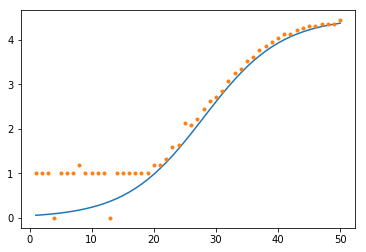

In [210]:
Result66=F_sigma(T,4.5,-28,0.16)
plt.plot(T, Result66, '-',T,R_frame3[66],'.')

[  4.53522901 -27.10999892   0.15713476]


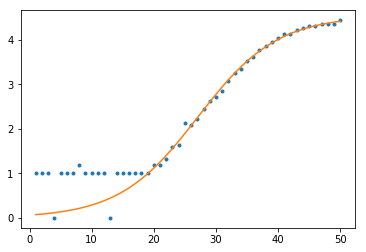

In [211]:
#perform the fit
Result66=Function_fit(T,R_frame3[66])

Tuve que hacer el fitting a partir del punto 19 (punto desidido a partir del grafico de los radios) por ser el momento donde se supera el "ruido"

In [229]:
def fit_radio(xdata,Rdata,nc,init,end):
    R_fit={}
    for i in range(nc):
        R_fit[i]=Function_fit(xdata,Rdata[i],init,end,i)
    return(R_fit)

[  4.92191164 -28.16159448   0.57577909]


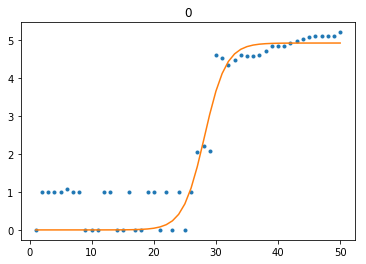

[  4.89324761 -30.09924176   0.21801583]


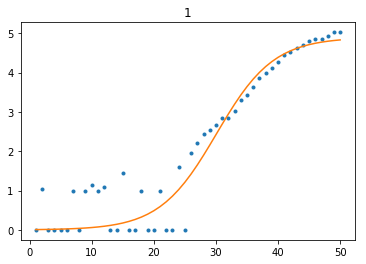

[  4.64280265 -30.03556588   0.17188546]


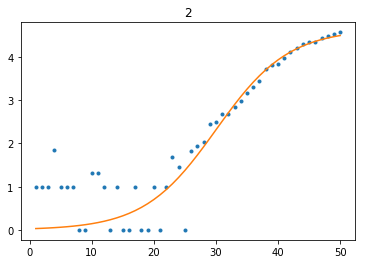

[  4.87154535 -28.49108432   0.1978948 ]


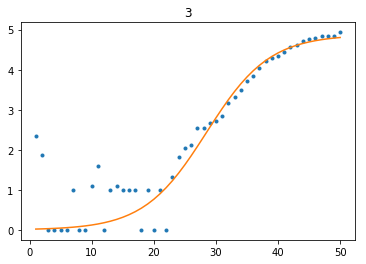

[  4.85208519 -29.95913233   0.22591933]


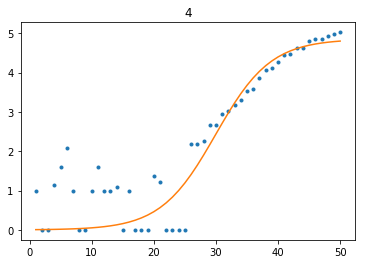

[  4.45027085 -27.80646349   0.18816741]


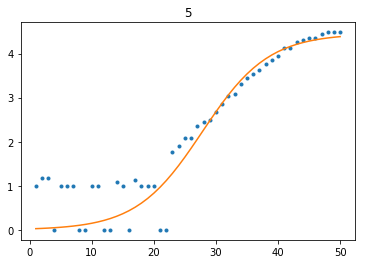

[  4.60705108 -25.99939415   0.14858347]


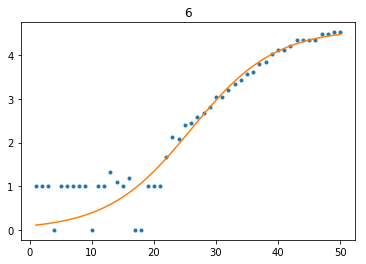

[  4.12680728 -26.75164077   0.19642151]


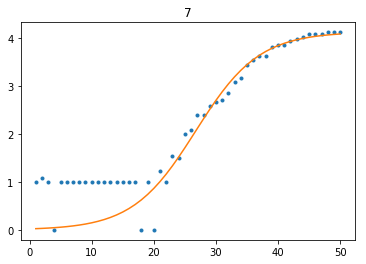

[  4.41329295 -27.57548176   0.17195861]


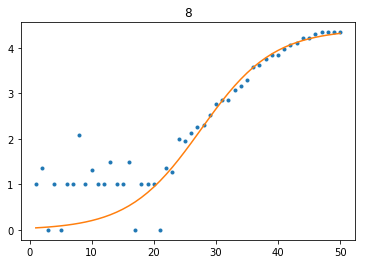

[  4.19646021 -28.12090821   0.24264246]


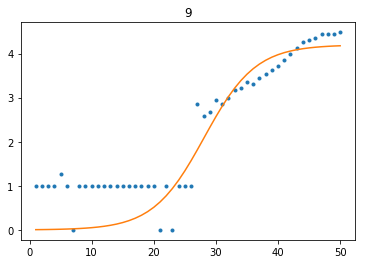

[  4.32585878 -27.47401145   0.19016276]


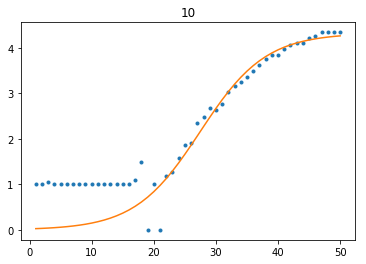

[  4.87390557 -28.24712395   0.18081651]


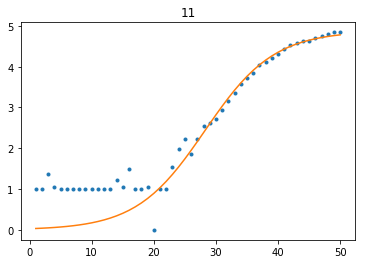

[  4.26189258 -30.93322851   0.15162997]


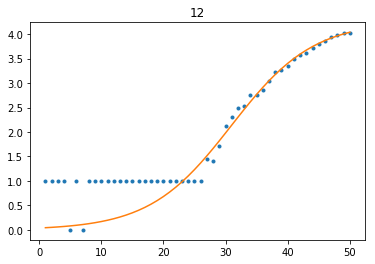

[  5.02306067 -27.71711229   0.18413894]


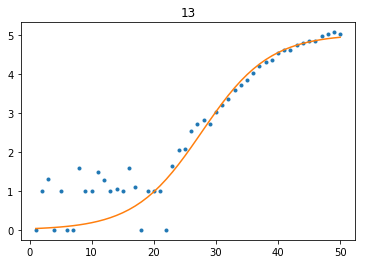

[  5.02793203 -37.73256025   0.11458361]


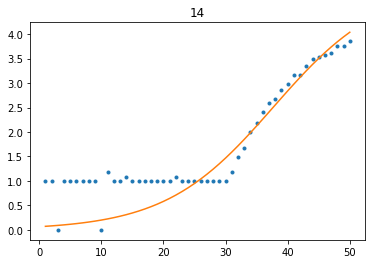

[  6.67407404 -32.89209913   0.15425889]


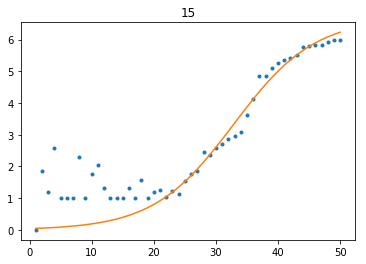

[  3.85877002 -27.19532343   0.16024313]


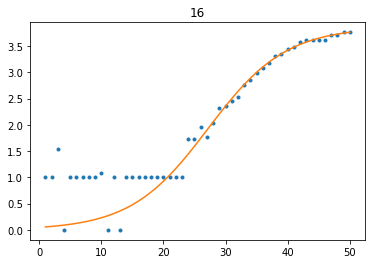

[  4.90320695 -29.00316753   0.18521994]


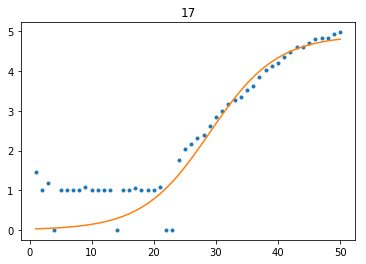

[  5.85715693 -29.57256177   0.12863798]


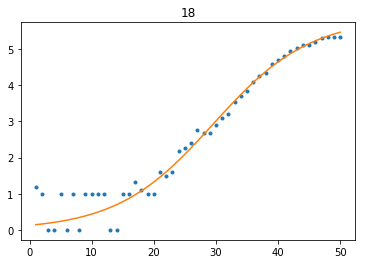

[  4.81108373 -28.37705888   0.17950549]


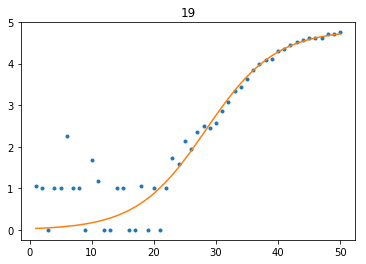

[  3.53792673 -26.41187053   0.27084744]


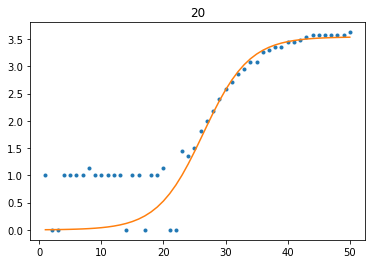

[  4.33135767 -33.1599898    0.1193755 ]


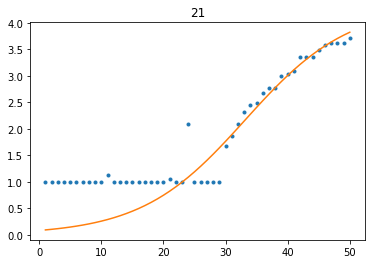

[  4.9455641  -29.72468428   0.15159991]


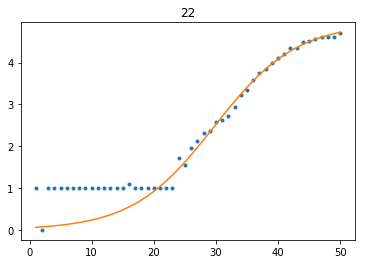

[  3.9970151  -26.68212153   0.19738747]


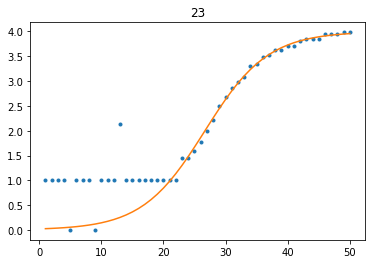

[  4.00301504 -24.86913929   0.1       ]


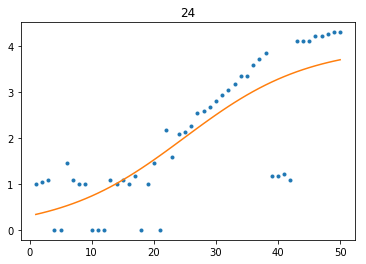

[  4.40473653 -28.47275571   0.19209369]


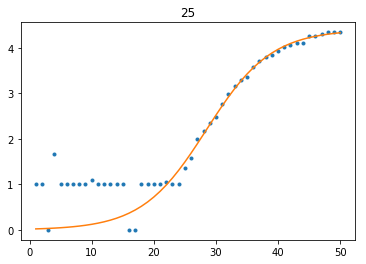

[  4.26633552 -30.96298741   0.14700072]


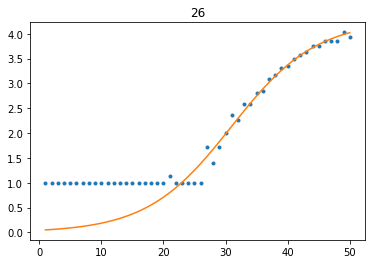

[  4.38772525 -26.64357886   0.18844977]


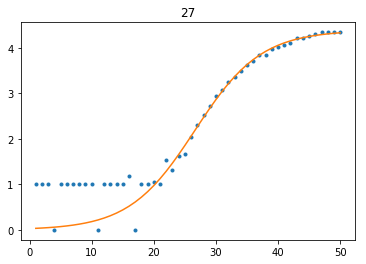

[  4.12211917 -26.81069353   0.26772235]


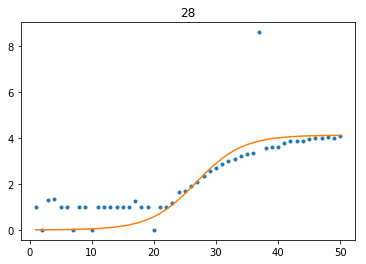

[  4.85652083 -25.7230622    0.180292  ]


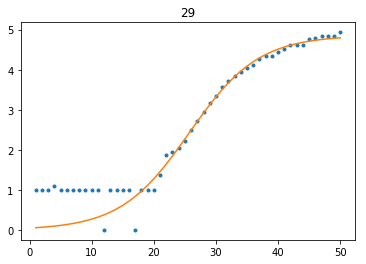

[  4.7783756  -27.6780233    0.17019589]


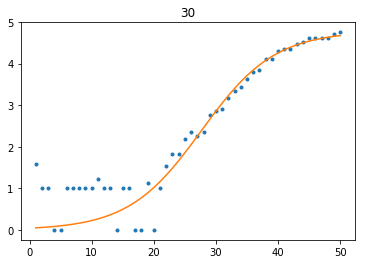

[  3.63642734 -29.47914521   0.17425128]


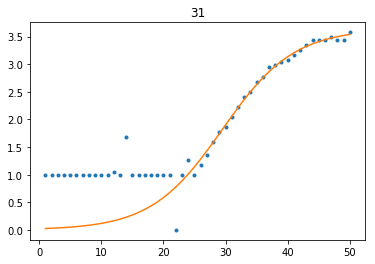

[  4.18129301 -26.68910152   0.15443707]


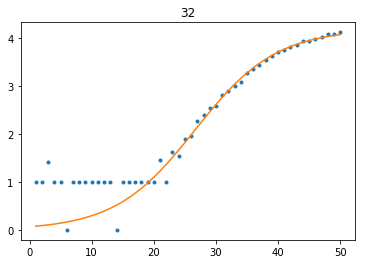

[  4.72136216 -27.55486415   0.23476736]


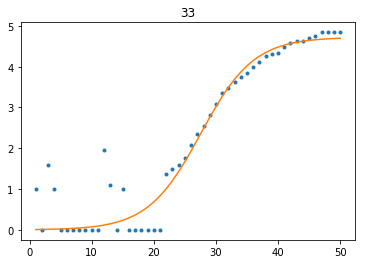

[  5.03490048 -27.48073667   0.17416005]


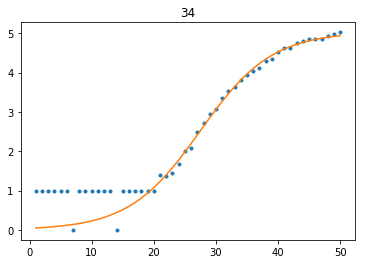

[  4.67757175 -26.38902613   0.17422566]


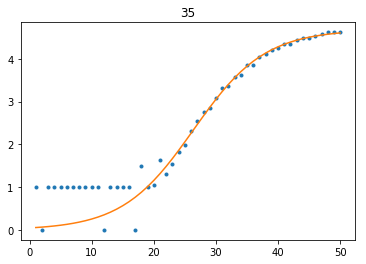

[  3.42479964 -31.7279705    0.21132654]


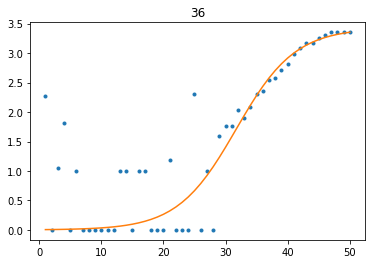

[  4.38226449 -27.61948703   0.23990539]


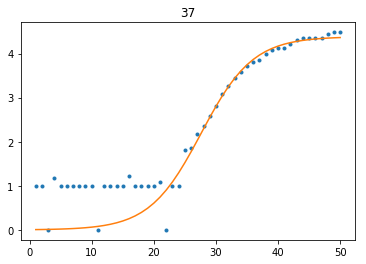

[  5.20415861 -31.66196395   0.16262605]


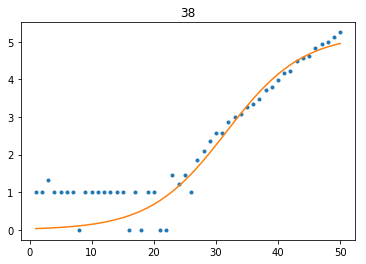

[  4.0816641  -27.87992457   0.21525881]


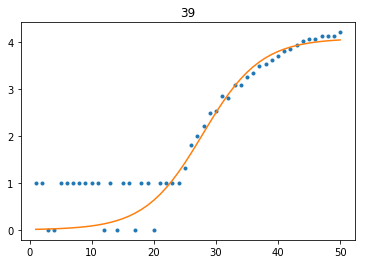

[  6.86868489 -32.28660073   0.13684356]


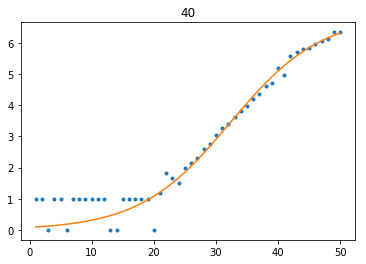

[  3.81615983 -28.39325248   0.17097097]


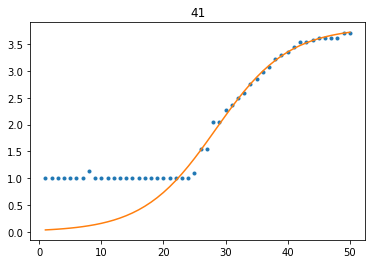

[  4.18920169 -27.69271727   0.1648673 ]


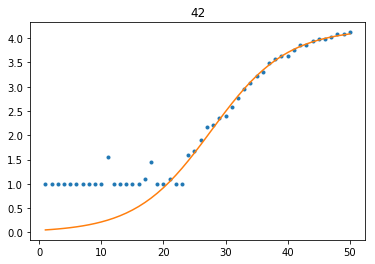

[  3.72485542 -28.65167853   0.1550117 ]


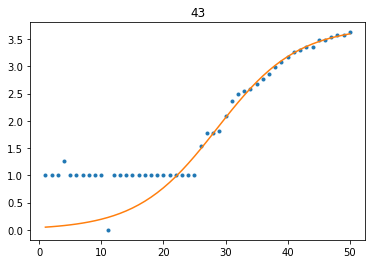

[  4.60416273 -28.02151724   0.22518893]


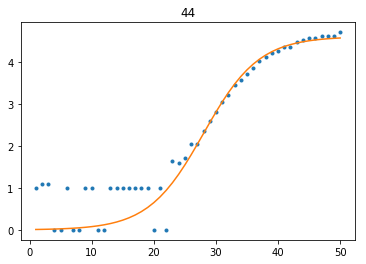

[  4.53080156 -30.10340403   0.19610725]


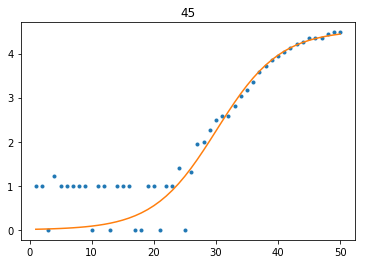

[  4.6409099  -28.39489877   0.20760077]


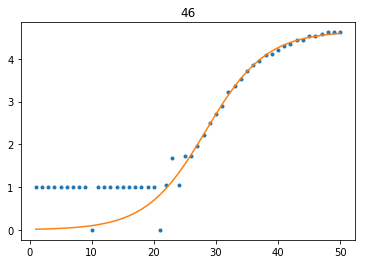

[  4.36275006 -28.26627275   0.20092196]


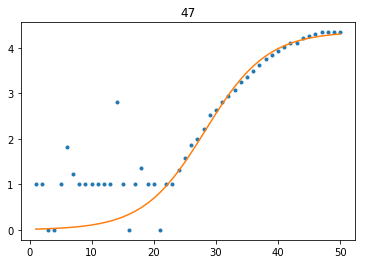

[  4.76284986 -27.30534868   0.20752305]


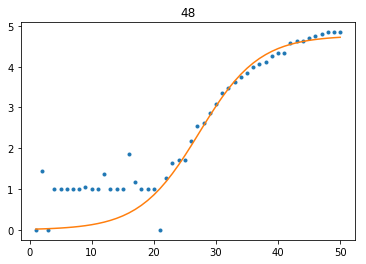

[  4.7590292  -29.18080903   0.17716695]


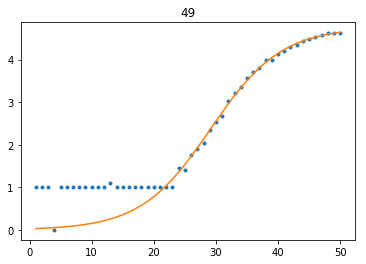

[  4.67028613 -28.17993913   0.158131  ]


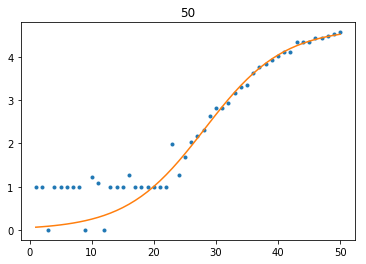

[  4.50599426 -28.66367473   0.15921418]


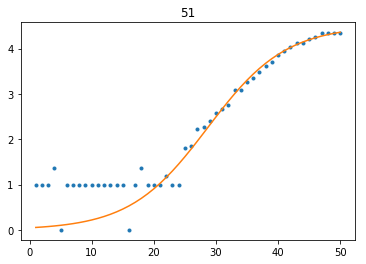

[  4.55936999 -28.69037936   0.20364702]


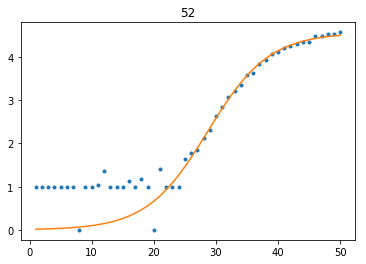

[  4.71746767 -28.34871464   0.24967698]


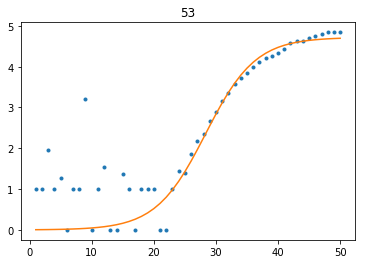

[  4.89621387 -28.30453566   0.19113849]


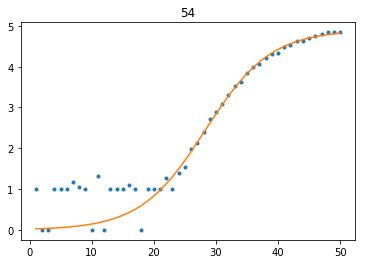

[  4.93256813 -27.8167247    0.18886728]


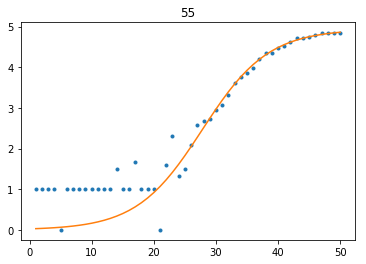

[  4.87618796 -27.55307281   0.21956736]


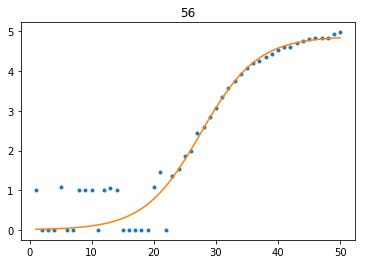

[  4.5473657  -27.56015284   0.17293142]


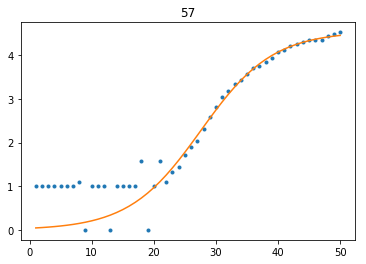

[  4.44207988 -28.72137832   0.17546044]


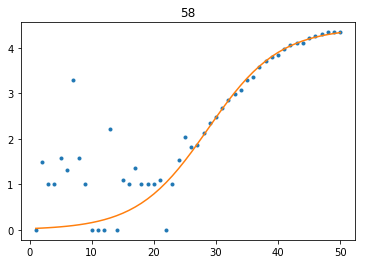

[  4.81506995 -27.96155304   0.22311631]


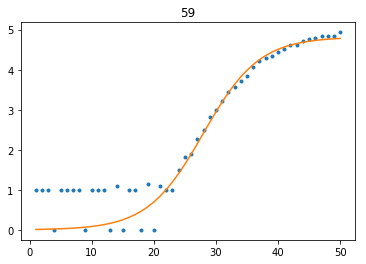

[  4.80936374 -31.11537724   0.14990311]


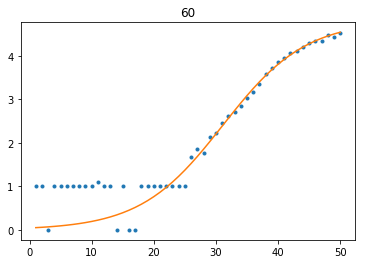

[  4.80917238 -32.06517081   0.13808786]


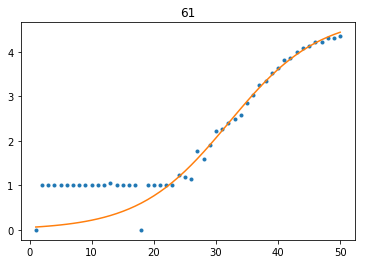

[  5.57453872 -27.30220373   0.1       ]


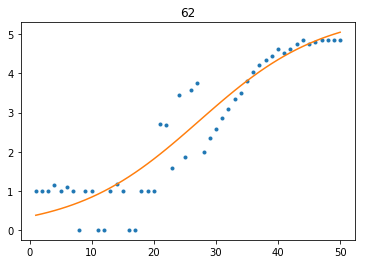

[  4.3596834  -28.97063451   0.20034414]


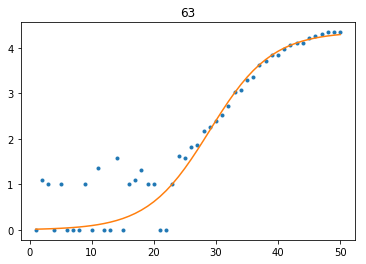

[  4.47485028 -30.65856832   0.18202805]


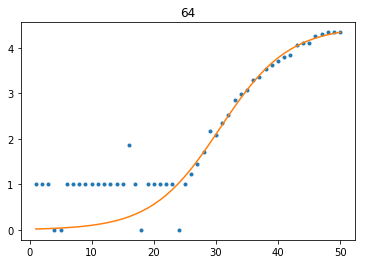

[  4.67923088 -28.76134647   0.20843566]


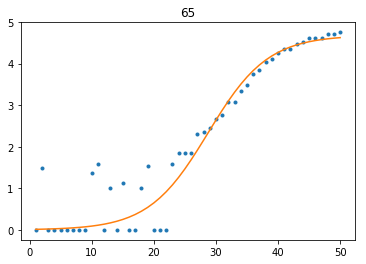

[  4.53522876 -27.10999818   0.1571348 ]


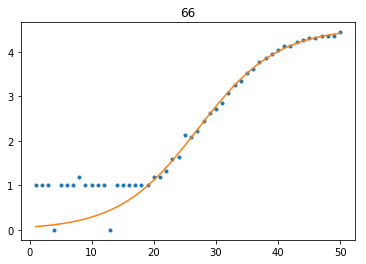

[  5.05091073 -30.22623275   0.17267204]


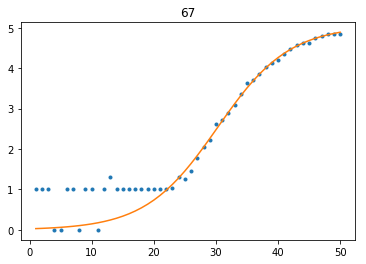

[  4.85595535 -27.83571498   0.18712701]


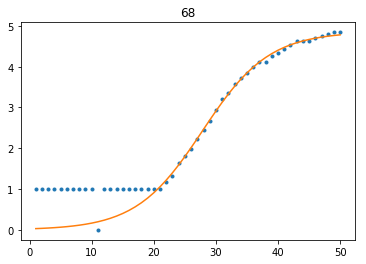

[  4.61993795 -31.46605686   0.15131507]


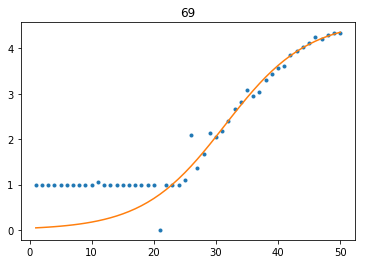

[  4.26253844 -31.03410912   0.15410254]


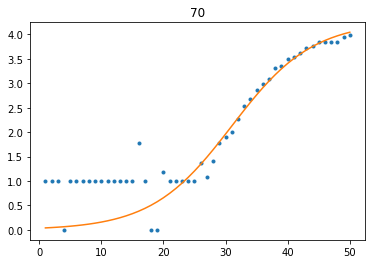

[  4.58495195 -28.09548555   0.2292134 ]


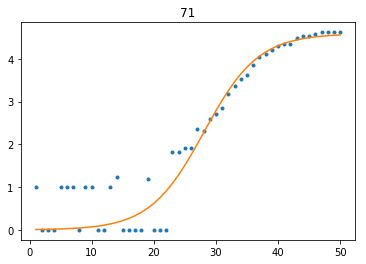

[  4.09972201 -33.57063109   0.11605528]


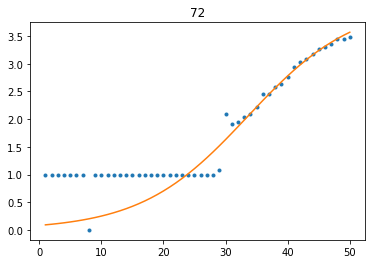

[  4.45002327 -26.54617205   0.18929003]


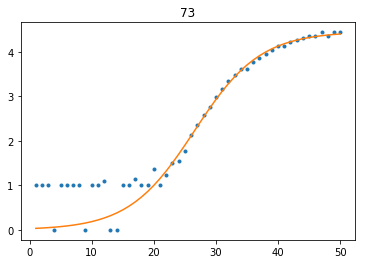

[  4.44409386 -32.85581619   0.12805853]


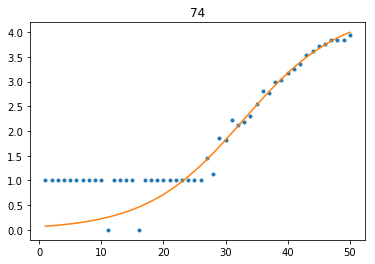

[  4.95525013 -27.89519105   0.18891196]


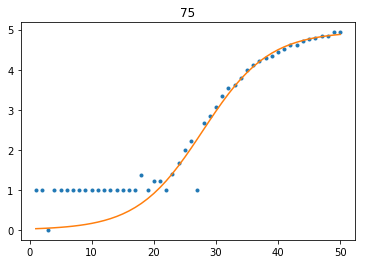

[  4.22347392 -29.84101758   0.28547143]


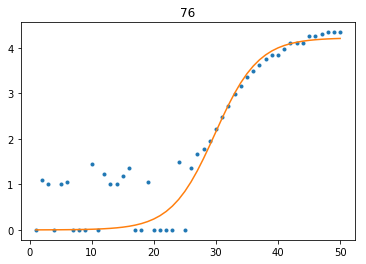

[  3.88614292 -27.70939864   0.25394952]


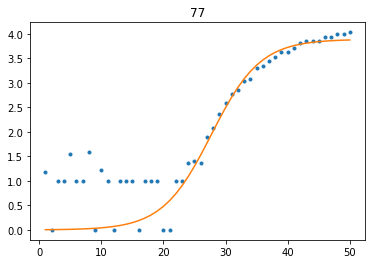

[  5.04877546 -30.0855617    0.17709002]


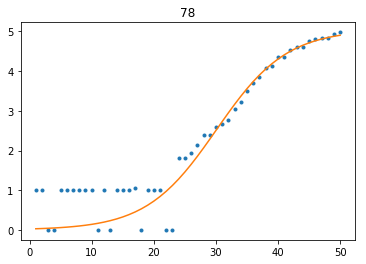

[  4.01788813 -31.31392864   0.18489315]


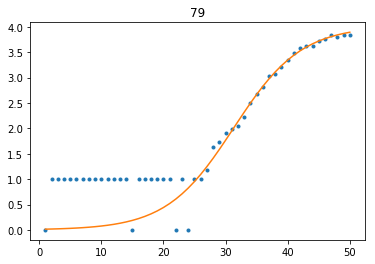

[  4.58475891 -27.81727875   0.1630545 ]


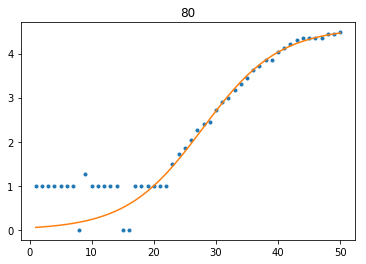

[  4.13356481 -26.87382001   0.16424652]


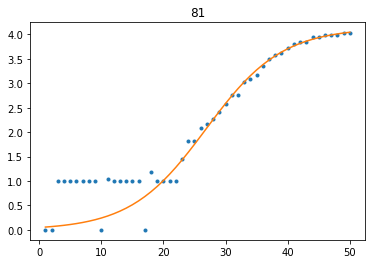

[  4.17254147 -35.3524863    0.12893803]


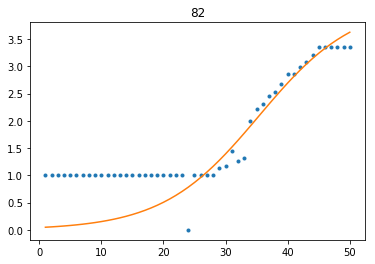

[  4.55408267 -29.05830675   0.15674954]


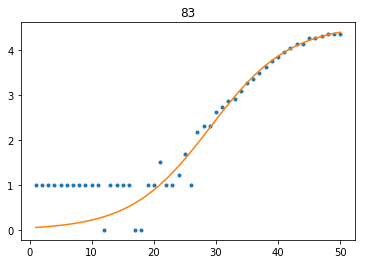

[  4.34081609 -28.96849603   0.22525614]


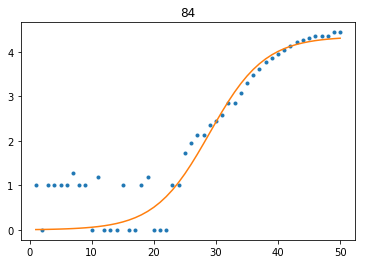

[  4.58032391 -27.44448387   0.1550013 ]


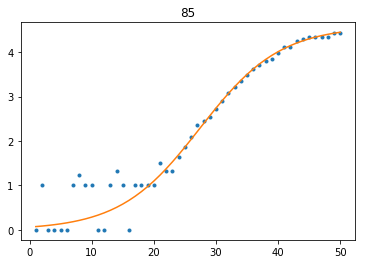

[  4.56748252 -32.28258996   0.18799017]


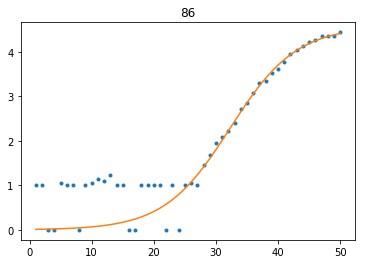

[  4.42725971 -29.83551859   0.17233122]


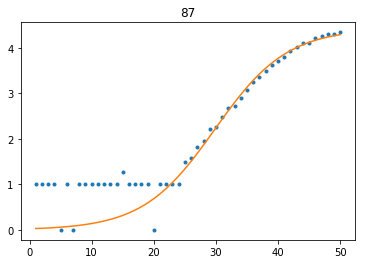

[  3.58773686 -26.40396881   0.21003954]


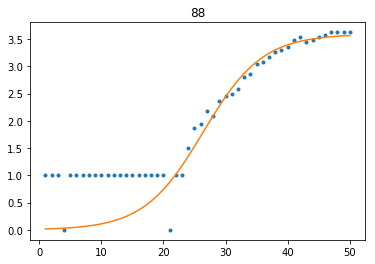

[  4.60890229 -29.38568631   0.16221189]


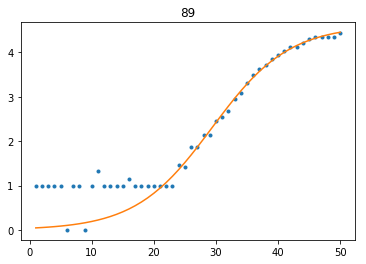

[  4.13051282 -27.21681068   0.16972571]


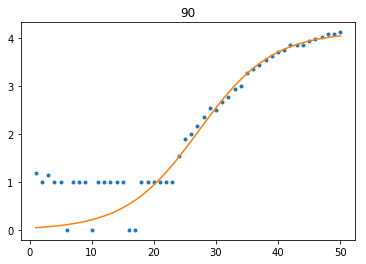

[  4.53677539 -27.64438996   0.17761296]


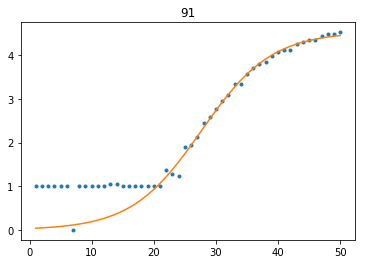

[  3.82598213 -27.52933546   0.27107762]


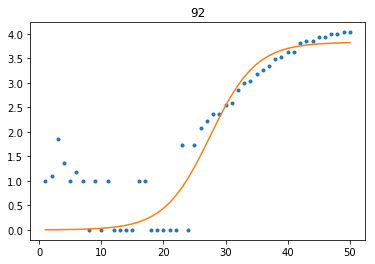

[  3.63355148 -27.35634637   0.19971486]


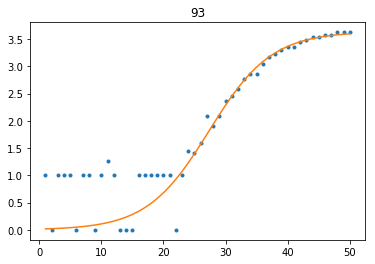

[  4.22438588 -27.69670387   0.1757344 ]


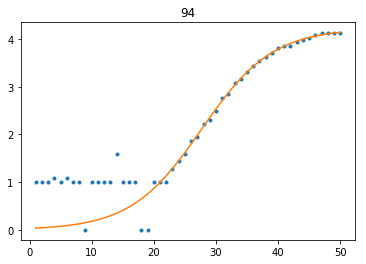

[  4.44533244 -28.78527902   0.20518548]


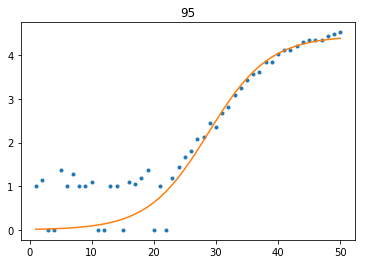

[  4.80067263 -27.65760256   0.21456582]


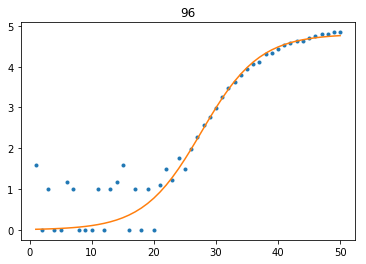

[  3.99266882 -28.32167738   0.18071018]


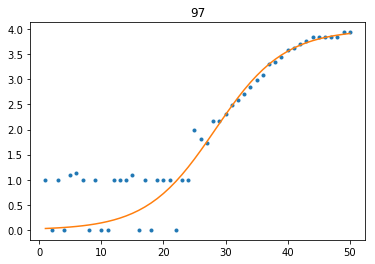

[  3.84785739 -30.23966649   0.13718643]


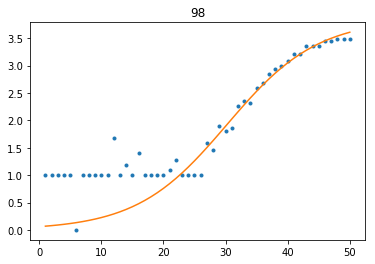

[  4.03553345 -31.24522191   0.14405206]


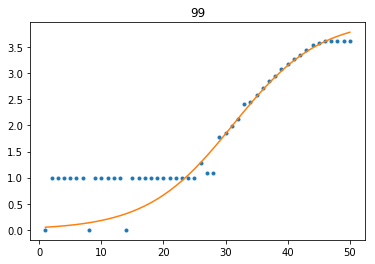

[  4.05099703 -29.51502062   0.17291853]


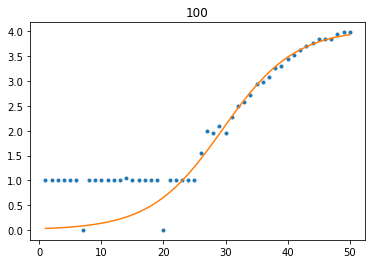

[  5.51163201 -34.41685743   0.55355009]


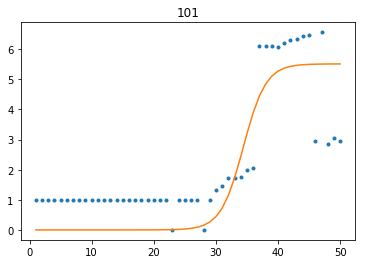

[  5.03872661 -26.15034934   0.16430551]


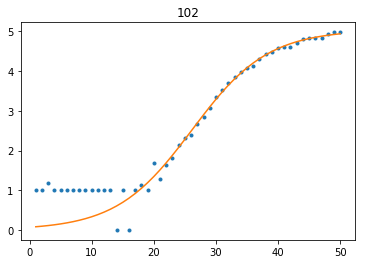

[  4.51647042 -28.69698853   0.22800302]


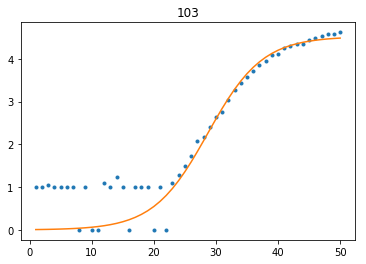

[  4.48576164 -30.86971748   0.17109063]


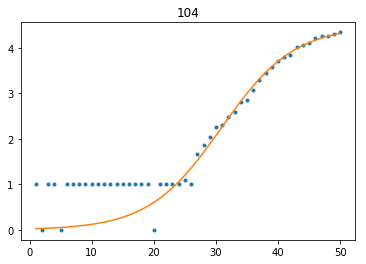

[  4.77307571 -32.86338912   0.14899544]


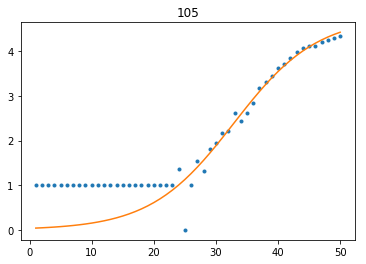

[  4.51191668 -28.75292711   0.21159109]


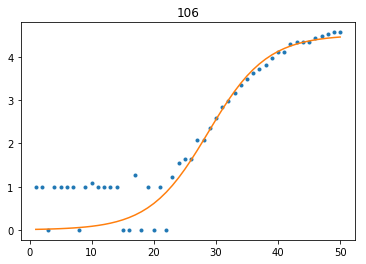

[  4.32659393 -32.80629862   0.12734645]


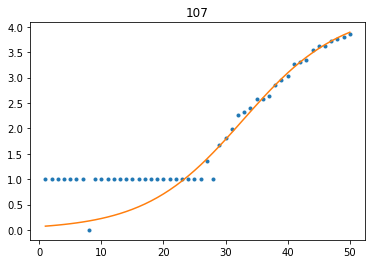

[  5.17412255 -29.33084599   0.15956298]


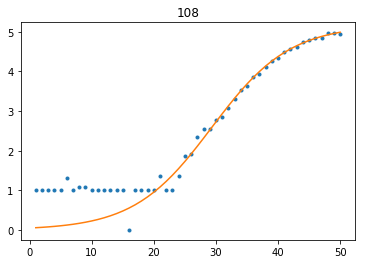

[  4.87906264 -40.20413563   0.1       ]


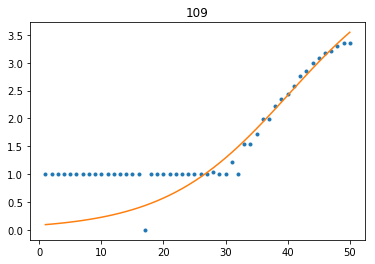

[  8.29435333 -45.36583271   0.10018547]


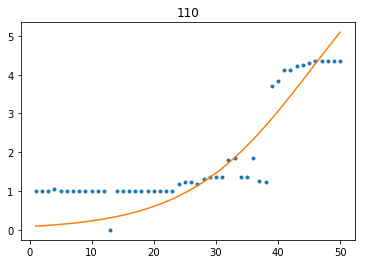

[  4.13851132 -29.52896085   0.15856919]


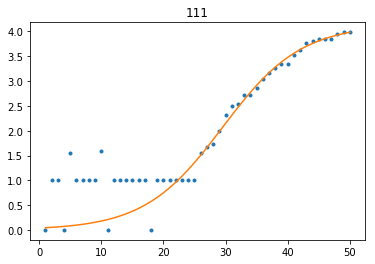

[  4.1502108  -28.68706739   0.16247674]


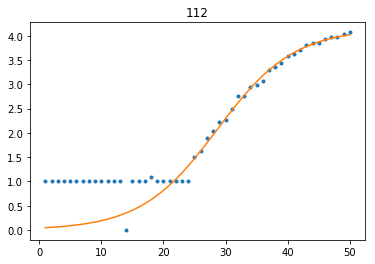

[  4.5188106  -30.74663967   0.15850471]


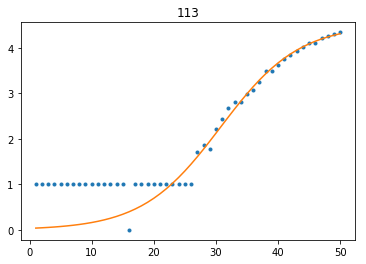

[  4.43133337 -30.46396195   0.20514689]


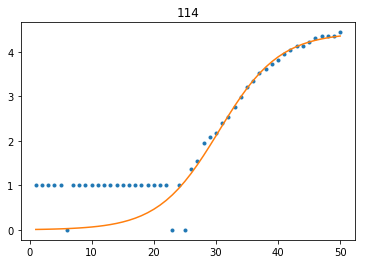

[  4.63179454 -28.90213089   0.16283923]


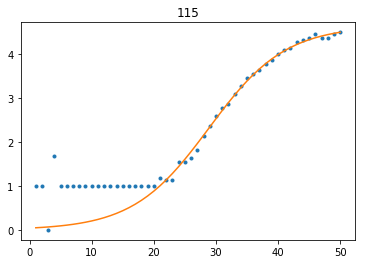

[  4.15435877 -28.92573897   0.15763204]


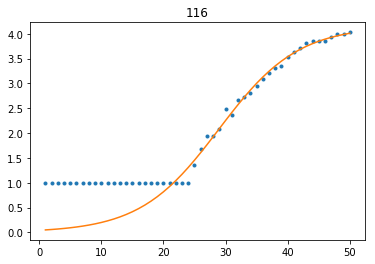

[  4.4365379  -33.45760263   0.12503701]


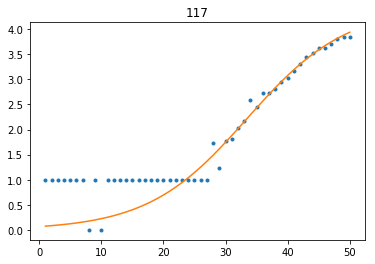

[  4.03256644 -29.17015718   0.20978762]


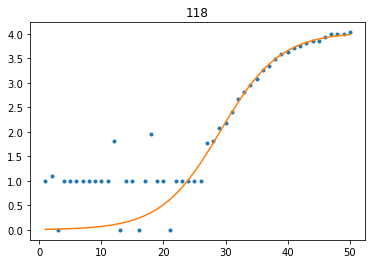

[  4.18334213 -30.54888644   0.24295827]


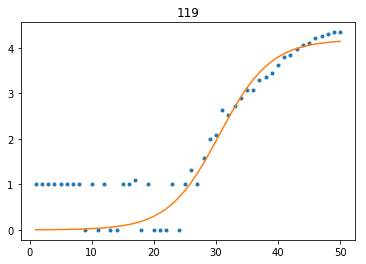

[  4.58865548 -31.34044542   0.16612521]


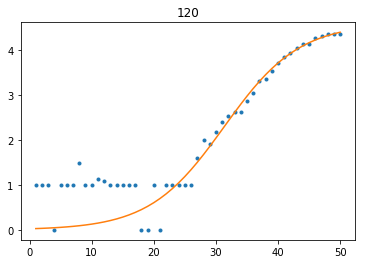

[  4.68310871 -29.09142738   0.15514581]


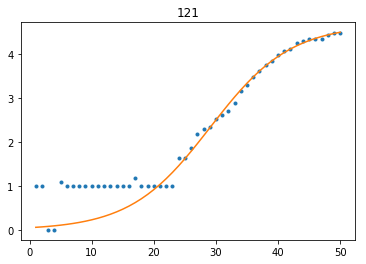

[  4.04793327 -35.22520642   0.13171971]


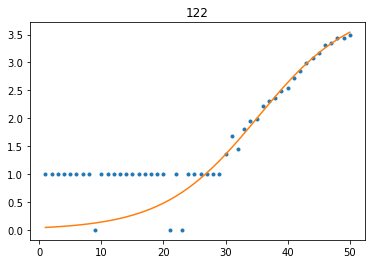

[  4.45262203 -29.15185241   0.17971336]


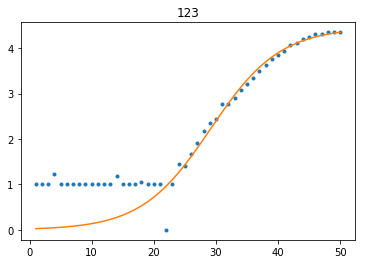

[  4.75796898 -29.31086178   0.18345308]


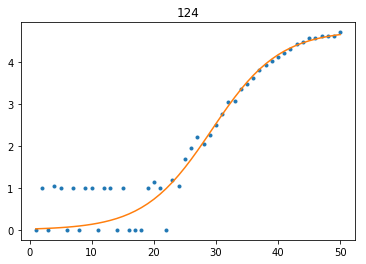

[  4.03484229 -29.96033778   0.20485291]


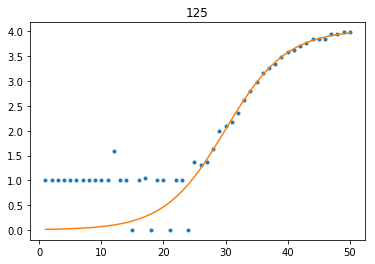

[  4.25234161 -29.89282383   0.23008709]


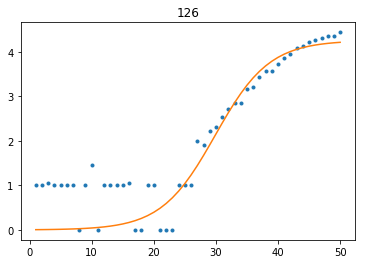

[  4.6320298  -29.71475714   0.16158814]


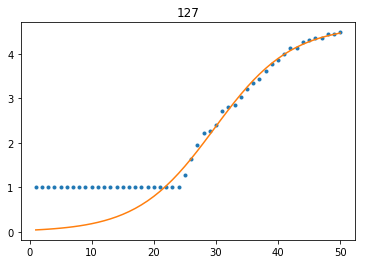

[  4.0441681  -30.90245231   0.17312635]


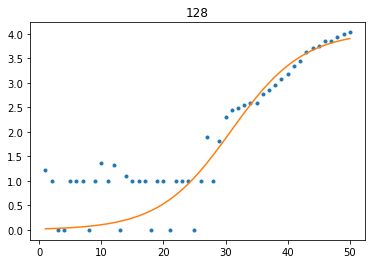

[  4.47630681 -30.36213347   0.1999418 ]


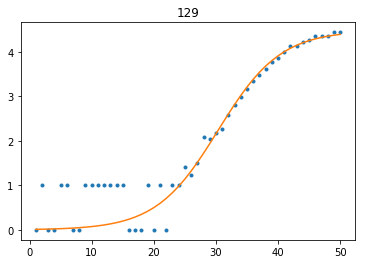

[  4.02277314 -29.25515989   0.19163055]


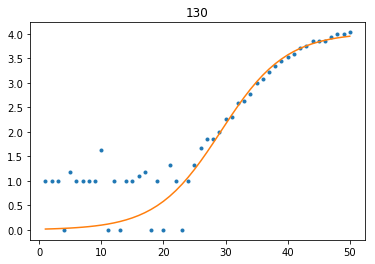

[  4.88139581 -29.9240486    0.196494  ]


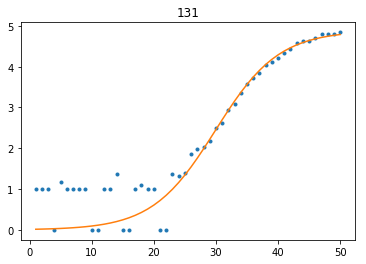

[  4.25902984 -29.60615154   0.15649837]


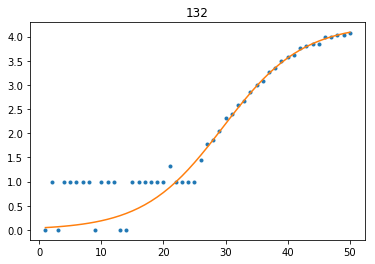

[  3.99225438 -31.76434418   0.16948292]


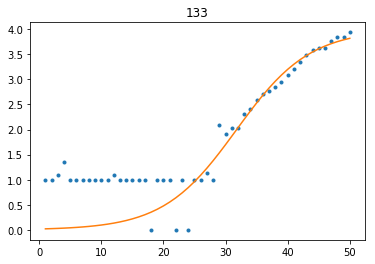

[  4.60534713 -31.93833624   0.26054733]


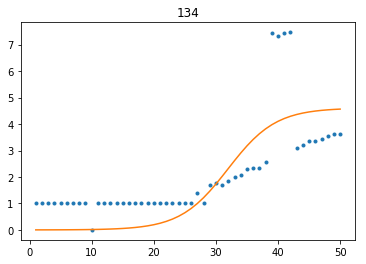

In [230]:
R_fitS=fit_radio(T,R_frame3,NC,19,-1)

Now we should export and save our results. For this aim, is good to put fluorescence and size in the same dictionary:

In [ ]:
# I think is good to save the time vector, the 
def Final_Data(rois,R,t,nc)
    Gdat = {}
    for i in nc:
        GDat[i]= np.zeros((rois[i].shape,len(R),len(t)))
        

In [497]:
import csv

In [ ]:
w = csv.writer(open("output.csv", "w"))
for key, val in dict.items():
    w.writerow([key, val])

In [124]:
%matplotlib auto
idx=66
plt.figure(figsize=(12,10))
for i in range(T.shape[0]):

            #plt.imshow(rois[idx+20][:,:,-1], interpolation='none', vmin=0, vmax=mx)
            #plt.colorbar()
    roi = ACRoisS[idx][:,:,i]
    plt.imshow(roi, interpolation='none', vmin=0, vmax=255,cmap='gray')
    
    # Uncomment here to save figures as images
    #plt.savefig('AnalysisOutput/rois2/rois_step%d.png'%(i))
    #plt.title('Colonies 1-20')
    plt.pause(0.1)
%matplotlib inline

Using matplotlib backend: Qt5Agg


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

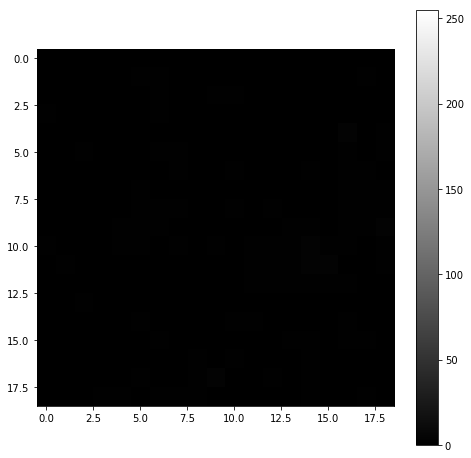

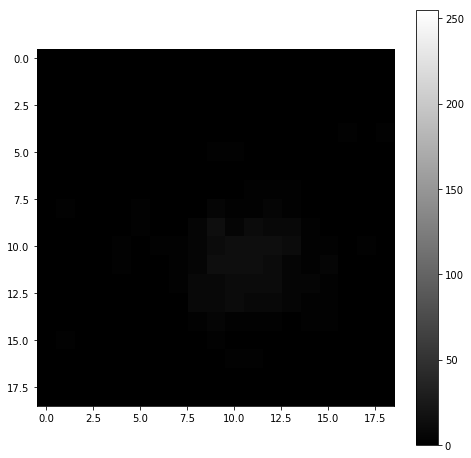

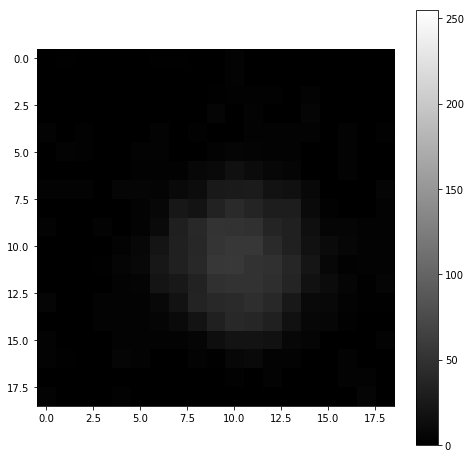

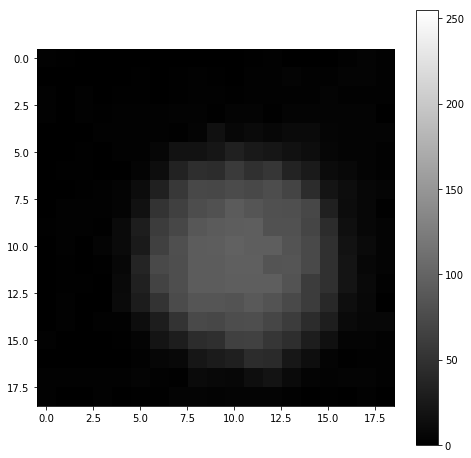

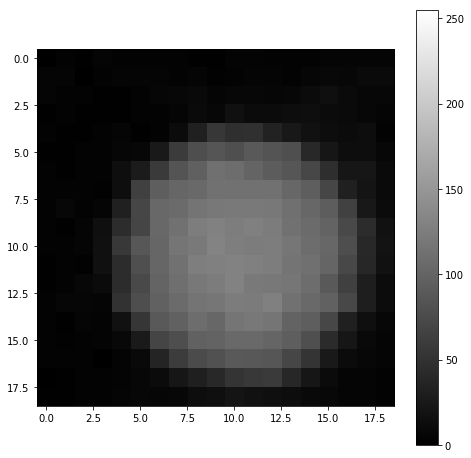

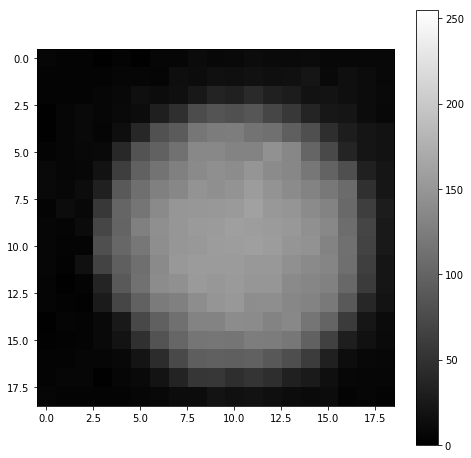

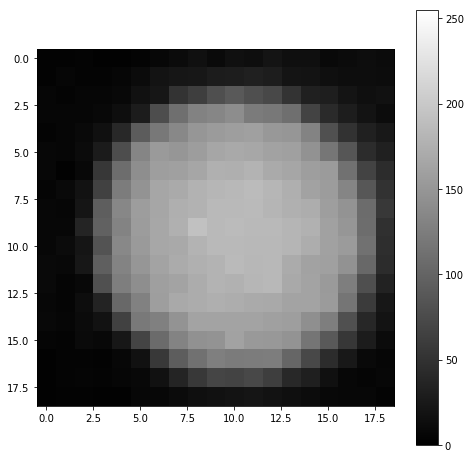

In [134]:
%matplotlib inline
idx=66
Times=[14,24,29,34,39,44,49]
for i in Times :

            #plt.imshow(rois[idx+20][:,:,-1], interpolation='none', vmin=0, vmax=mx)
            #plt.colorbar()
    plt.figure(figsize=(8,8))        
    roi = ACRoisS[idx][:,:,i]
    plt.imshow(roi, interpolation='none', vmin=0, vmax=255,cmap='gray')
    plt.colorbar()
    # Uncomment here to save figures as images
    plt.savefig('singlecol/rois_step%d.png'%(i+1))
    #plt.title('frame'+str(i+1))

In [125]:
print(T)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.]


### Parameter estimation from data

We now have information about sub-populations of bacteria (colonies) on the same plate. The fluorescence in each region of interest estimates the time varying fluorescent protein level in each colony. The radius (or $R^2$) approximates the size of each sub-population (colony) and so is similar to optical density (OD) in a bulk plate-reader experiment. 

Lets write a simple model of fluorescent protein expression from a single cell:

\begin{equation}
\frac{dF}{dt} = k(t) - (\mu(t) + \delta(t))F
\end{equation}

where $F$ is the cell's fluorescent protein concentration, which is produced at time-varying rate $k(t)$. The cell grows at relative rate $\mu(t)=(1/V)dV/dt$ ($V=$volume) causing dilution. The protein is degraded at rate $\delta(t)$.

For the proteins we are using we will assume that $\delta(t)=0$ for all times. We measure the total fluorescence intensity, which is the concentration $F$ multiplied by the total volume of the colony $V_{tot} \approx \pi R^2$. Hence,

\begin{equation}
I(t) = F(t)V(t) \approx F(t) \pi R^2(t)
\end{equation}

From these equations it is possible to derive:

\begin{equation}
k(t) = \frac{1}{V(t)}\frac{dI}{dt}
\end{equation}

Lets get $V$ and $I$ from our data:

In [235]:
import math
from math import pi

# Approximate volume as Pi*R^2
V = {}
for i in range(NC):
    r=R_fitS[i][0]
    V[i] = pi*r*r
    


Ahora deberia computar las circular ROIS para cada tiempo con las nuevas áreas de los radios obtenidos.

In [231]:
print(R_fitS.iteritems())

AttributeError: 'dict' object has no attribute 'iteritems'

In [234]:
R_fitS[1][1]

array([  4.89324761, -30.09924176,   0.21801583])